In [1]:


from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from surprise import Reader, Dataset, SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, \
    KNNWithZScore, BaselineOnly, CoClustering, accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
init_notebook_mode(connected=True)
import numpy as np
import pandas as pd
import csv

import sklearn
from sklearn.decomposition import TruncatedSVD as TSVD
from sklearn.cross_decomposition import PLSSVD
columns = ['id','task','TaskId','rating']
frame = pd.read_csv('DataRecommenderSystem/DataVisitVisitor.csv',sep=',', names=columns)
frame.head()

,id,task,TaskId,rating
0,0,1000,1,6
1,1,1110,2,6
2,2,1100,3,7
3,3,1010,4,8
4,4,1000000,5,7


In [2]:
columns2 =['TaskId','TaskName','Task']
tasks = pd.read_csv('DataRecommenderSystem/TaskVisitVisitor.csv', sep=',', names = columns2, encoding='latin-1')
task_names = tasks[['TaskId','TaskName','Task']]
task_names.head()

,TaskId,TaskName,Task
0,1,Task1,1000
1,2,Task2,1110
2,3,Task3,1100
3,4,Task4,1010
4,5,Task5,1000000


In [3]:
combined_task_data = pd.merge(frame, task_names, on='TaskId')
combined_task_data.head()

,id,task,TaskId,rating,TaskName,Task
0,0,1000,1,6,Task1,1000
1,15,1000,1,8,Task1,1000
2,17,1000,1,4,Task1,1000
3,25,1000,1,5,Task1,1000
4,32,1000,1,0,Task1,1000


In [4]:
combined_task_data.groupby('TaskId')['rating'].count().sort_values(ascending=True).head()

filter_interview = combined_task_data['TaskId']==0
combined_task_data[filter_interview]['TaskName'].unique()

array([], dtype=object)

In [5]:
rating_crosstab = combined_task_data.pivot_table(values='rating', index='id', columns=['TaskName','Task'], fill_value=0.01)
rating_crosstab

TaskName,Task1,Task10,Task11,Task2,Task3,Task4,Task5,Task6,Task7,Task8,Task9
Task,1000,1000010,1000110,1110,1100,1010,1000000,1101010,101010,100010,100110
id,,,,,,,,,,,
0,6.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
1,0.01,0.01,0.01,6.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01
2,0.01,0.01,0.01,0.01,7.00,0.01,0.01,0.01,0.01,0.01,0.01
3,0.01,0.01,0.01,0.01,0.01,8.00,0.01,0.01,0.01,0.01,0.01
4,0.01,0.01,0.01,0.01,0.01,0.01,7.00,0.01,0.01,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...
995,0.01,0.01,0.01,0.01,3.00,0.01,0.01,0.01,0.01,0.01,0.01
996,0.01,0.01,0.01,0.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01


In [6]:
rating_crosstab.shape
X = rating_crosstab.T
X.shape

(11, 1000)

In [7]:
truncated_SDV = TSVD(n_components=11, random_state=42)
resultant_matrix = truncated_SDV.fit_transform(X)

resultant_matrix.shape

(11, 11)

In [8]:
corr_mat = np.corrcoef(resultant_matrix)
corr_mat.shape
task_names = rating_crosstab.columns
task_list = list(task_names)
task_list
task = task_list.index(('Task1',1000))
task
corr_1 = corr_mat[task]
corr_1.shape
corr_1

with open('DataRecommenderSystem/recommenderSystemVisit.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(corr_1)
    writer.writerow(list(task_names[(corr_1<=1) & (corr_1 > -0.09)]))



In [9]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
#add
data = frame['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / frame.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} Visit Task-ratings'.format(frame.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)
#add

In [10]:
#add
# Create trace
trace = go.Histogram(x = combined_task_data.TaskId,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 1000,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Visit Task',
                   xaxis = dict(title = 'Number of Ratings Per Task'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.1)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)
#add

#add
# Create trace
trace = go.Histogram(x = combined_task_data.id,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 1000,
                                  size = 100))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Visit Ratings Per User',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.1)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)
#add

In [11]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(combined_task_data[['id', 'TaskId', 'rating']], reader)

In [12]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    print(algorithm)
    results = cross_validate(algorithm, data, cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
smt = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   
print(smt)
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, cv=5, verbose=False)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

{'test_rmse': array([3.21352727, 3.14855126, 3.02884645, 3.16265848, 3.03161392]),
 'test_mae': array([2.81904201, 2.71642329, 2.54434101, 2.72333096, 2.52920409]),
 'fit_time': (0.0020003318786621094,
  0.0019974708557128906,
  0.0019998550415039062,
  0.002000093460083008,
  0.0029981136322021484),
 'test_time': (0.0010006427764892578,
  0.002000093460083008,
  0.0019998550415039062,
  0.0019998550415039062,
  0.0009999275207519531)}

In [13]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)



Estimating biases using als...
RMSE: 3.1501


3.1500795634869654

In [14]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]
print(best_predictions)
print(worst_predictions)

     uid  iid  rui       est                    details  Iu  Ui       err
218  344    9  5.0  5.060844  {'was_impossible': False}   0  63  0.060844
135  955    9  5.0  5.060844  {'was_impossible': False}   0  63  0.060844
20   963    6  6.0  5.919686  {'was_impossible': False}   0  60  0.080314
157  863    6  6.0  5.919686  {'was_impossible': False}   0  60  0.080314
5    957    6  6.0  5.919686  {'was_impossible': False}   0  60  0.080314
17   112    5  5.0  4.894059  {'was_impossible': False}   0  78  0.105941
83   347    5  5.0  4.894059  {'was_impossible': False}   0  78  0.105941
68   321    5  5.0  4.894059  {'was_impossible': False}   0  78  0.105941
88   859    5  5.0  4.894059  {'was_impossible': False}   0  78  0.105941
180   85   11  5.0  4.847574  {'was_impossible': False}   0  46  0.152426
     uid  iid  rui       est                    details  Iu   Ui       err
177  477    4  0.0  5.235367  {'was_impossible': False}   0   76  5.235367
244  377    4  0.0  5.235367  {'was_

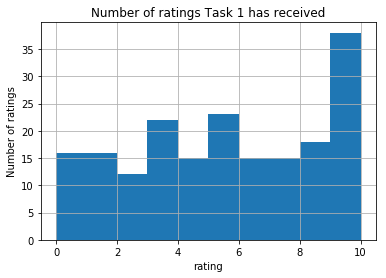

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
combined_task_data.loc[combined_task_data['TaskId'] == 1]['rating'].hist()
#fig = plt.figure()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings Task 1 has received')
plt.show();


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

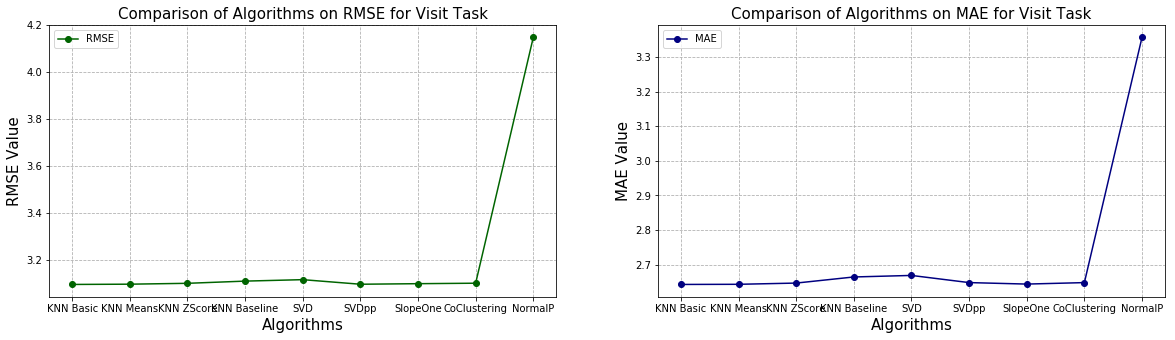

,id,task,TaskId,rating
count,1000.000000,1.000000e+03,1000.000000,1000.000000
mean,499.500000,3.347137e+05,4.770000,5.131000
std,288.819436,4.677717e+05,3.179183,3.098296
min,0.000000,1.000000e+03,1.000000,0.000000
25%,249.750000,1.010000e+03,2.000000,3.000000
50%,499.500000,1.110000e+03,4.000000,5.000000
75%,749.250000,1.000000e+06,7.000000,8.000000
max,999.000000,1.101010e+06,11.000000,10.000000


In [16]:
# SVD(), SVDpp(), SlopeOne(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()
knnbasic_cv = cross_validate(KNNBasic(), data, cv=5, verbose=False)
knnmeans_cv = cross_validate(KNNWithMeans(), data, cv=5, verbose=False)
knnz_cv = cross_validate(KNNWithZScore(), data, cv=5, verbose=False)
svd_cv = cross_validate(SVD(), data, cv=5, verbose=False)
svdpp_cv = cross_validate(SVDpp(), data, cv=5, verbose=False)
#nmf_cv = cross_validate(NMF(), data, cv=5, n_jobs=5, verbose=False)
slope_cv = cross_validate(SlopeOne(), data, cv=5, verbose=False)
coclus_cv = cross_validate(CoClustering(), data, cv=5, verbose=False)
normalPredictor_cv= cross_validate(NormalPredictor(),data, cv=5, verbose=False)
knnBaseline_cv = cross_validate(KNNBaseline(), data, cv=5, verbose=False)

print('Algorithm\t RMSE\t\t MAE\t\tTIME')
print()
print('KNN Basic', '\t', round(knnbasic_cv['test_rmse'].mean(), 6), '\t', round(knnbasic_cv['test_mae'].mean(), 6), '\t', knnbasic_cv['test_time'])
print('KNN Means', '\t', round(knnmeans_cv['test_rmse'].mean(), 6), '\t', round(knnmeans_cv['test_mae'].mean(), 6), '\t', knnmeans_cv['test_time'])
print('KNN ZScore', '\t', round(knnz_cv['test_rmse'].mean(), 6), '\t', round(knnz_cv['test_mae'].mean(), 6), '\t', knnz_cv['test_time'])
print('KNN Baseline', '\t', round(knnBaseline_cv['test_rmse'].mean(), 6), '\t', round(knnBaseline_cv['test_mae'].mean(), 6), '\t', knnBaseline_cv['test_time'])
print()
print('SVD', '\t\t', round(svd_cv['test_rmse'].mean(), 6), '\t', round(svd_cv['test_mae'].mean(), 6), '\t', svd_cv['test_time'])
print('SVDpp', '\t\t', round(svdpp_cv['test_rmse'].mean(), 6), '\t', round(svdpp_cv['test_mae'].mean(), 6), '\t', svdpp_cv['test_time'])
#print('NMF', '\t\t', round(nmf_cv['test_rmse'].mean(), 4), '\t', round(nmf_cv['test_mae'].mean(), 4))
print()
print('SlopeOne', '\t', round(slope_cv['test_rmse'].mean(), 6), '\t', round(slope_cv['test_mae'].mean(), 6), '\t', slope_cv['test_time'])
print('CoClustering', '\t', round(coclus_cv['test_rmse'].mean(), 6), '\t', round(coclus_cv['test_mae'].mean(), 6), '\t', slope_cv['test_time'])
print()
print('NormalPred', '\t', round(normalPredictor_cv['test_rmse'].mean(), 6), '\t', round(normalPredictor_cv['test_mae'].mean(), 6), normalPredictor_cv['test_time'])
print()

x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'KNN Baseline', 'SVD', 'SVDpp', 'SlopeOne', 'CoClustering', 'NormalP']
all_algos_cv = [knnbasic_cv, knnmeans_cv, knnz_cv, knnBaseline_cv, svd_cv, svdpp_cv, slope_cv, coclus_cv, normalPredictor_cv]

rmse_cv = [round(res['test_rmse'].mean(), 6) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 6) for res in all_algos_cv]

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE for Visit Task', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE for Visit Task', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()
frame.describe()

In [17]:
# Parameter space
svd_param_grid = {'n_epochs': [20, 25], 
                  'lr_all': [0.007, 0.009, 0.01],
                  'reg_all': [0.4, 0.6]}

svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5)
svdpp_gs.fit(data)

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5)
svd_gs.fit(data)

print('SVDpp - RMSE:', round(svdpp_gs.best_score['rmse'], 6), '; MAE:', round(svdpp_gs.best_score['mae'], 6))
print('SVD   - RMSE:', round(svd_gs.best_score['rmse'], 6), '; MAE:', round(svd_gs.best_score['mae'], 6))
#SVDpp best params
print('RMSE =', svdpp_gs.best_params['rmse'])
print('MAE =', svdpp_gs.best_params['mae'])
#SVD best params
print('RMSE =', svd_gs.best_params['rmse'])
print('MAE =', svd_gs.best_params['mae'])



SVDpp - RMSE: 3.103088 ; MAE: 2.648083
SVD   - RMSE: 3.106193 ; MAE: 2.650623
RMSE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}
MAE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}
RMSE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.6}
MAE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.6}


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

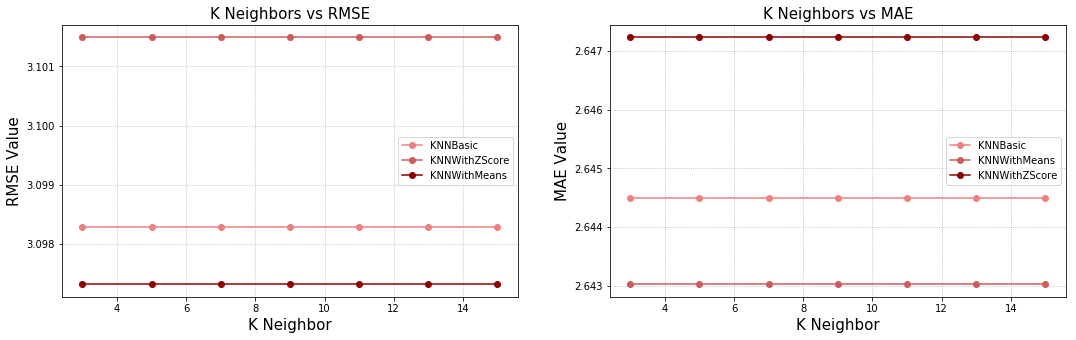

In [18]:
param_grid = {'k': [3, 5, 7, 9, 11, 13, 15]}

knnbasic_gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5)
knnbasic_gs.fit(data)

knnmeans_gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5)
knnmeans_gs.fit(data)

knnz_gs = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse', 'mae'], cv=5)
knnz_gs.fit(data)

x =  [3, 5, 7, 9, 11, 13, 15]
y1 = knnbasic_gs.cv_results['mean_test_rmse']
y2 = knnbasic_gs.cv_results['mean_test_mae']

y3 = knnmeans_gs.cv_results['mean_test_rmse']
y4 = knnmeans_gs.cv_results['mean_test_mae']

y5 = knnz_gs.cv_results['mean_test_rmse']
y6 = knnz_gs.cv_results['mean_test_mae']

plt.figure(figsize=(18,5))

plt.subplot(1, 2, 1)
plt.title('K Neighbors vs RMSE', loc='center', fontsize=15)
plt.plot(x, y1, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y5, label='KNNWithZScore', color='indianred', marker='o')
plt.plot(x, y3, label='KNNWithMeans', color='darkred', marker='o')

plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.subplot(1, 2, 2)
plt.title('K Neighbors vs MAE', loc='center', fontsize=15)
plt.plot(x, y2, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y4, label='KNNWithMeans', color='indianred', marker='o')
plt.plot(x, y6, label='KNNWithZScore', color='darkred', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.show()

In [27]:
import surprise
from surprise import SVD
from surprise import Dataset
from surprise import accuracy


lower_rating = frame['rating'].min()
upper_rating = frame['rating'].max()

reader = surprise.Reader(rating_scale =(0,10))
#data = surprise.Dataset.load_from_df(frame,reader)

alg=surprise.SVDpp()
output=alg.fit(data.build_full_trainset())

pred = alg.predict(uid=0,iid=1)
score = pred.est
print(score)

iids = frame['TaskId'].unique()
iids0 = frame.loc[frame['id']==0,'TaskId']
print(iids0)
iids_to_pred = np.setdiff1d(iids,iids0)

testset = [[0,iid,3.] for iid in iids_to_pred]
predictions = alg.test(testset)

pred_ratings = np.array([pred.est for pred in predictions])
i_max = np.argpartition(pred_ratings, -3)[-3:]
print(i_max)
iid = iids_to_pred[i_max[0]]
iid2=iids_to_pred[i_max[1]]
iid3=iids_to_pred[i_max[2]]
print('Top item for user 50 has TaskId {0} with pred rating {1}'.format(iid,pred_ratings[i_max[0]]))
print('Top item for user 50 has TaskId {0} with pred rating {1}'.format(iid2,pred_ratings[i_max[1]]))
print('Top item for user 50 has TaskId {0} with pred rating {1}'.format(iid3,pred_ratings[i_max[2]]))

with open('DataRecommenderSystem/recommenderSystemVisit.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(corr_1)
    writer.writerow(list([iid,iid2,iid3]))



5.712151966558652
0    1
Name: TaskId, dtype: int64
[9 6 2]
Top item for user 50 has TaskId 11 with pred rating 5.212691885730603
Top item for user 50 has TaskId 8 with pred rating 5.857990011208607
Top item for user 50 has TaskId 4 with pred rating 5.408227302612177
